## Libraries

In [17]:
from SoundDSConv import SoundDSConv
from AutoEncoderConv import AutoEncoderConv

import torch
from torch.utils.data import random_split
import torchaudio
from torchaudio import transforms
import os
import pandas as pd
import matplotlib.pyplot as plt

## Data Import

In [2]:
path_do_data_dir = 'DATA/'

# Get the list of files in the 'Piano Loops' directory using os.listdir()
piano_file_list = [path_do_data_dir + 'Piano Loops/' + filename for filename in os.listdir(path_do_data_dir + 'Piano Loops')]

# Create a pandas DataFrame with the "path_to_data" and "Instrument" columns for "Piano" entries
piano_df = pd.DataFrame({"path_to_data": piano_file_list, "Instrument": "Piano"})

# Get the list of files in the 'Guitar Loops' directory using os.listdir()
guitar_file_list = [path_do_data_dir + 'Guitar Loops/' + filename for filename in os.listdir(path_do_data_dir + 'Guitar Loops')]

# Create a DataFrame with the "path_to_data" and "Instrument" columns for "Guitar" entries
guitar_df = pd.DataFrame({"path_to_data": guitar_file_list, "Instrument": "Guitar"})


In [3]:
# Create Datasets
sample_rate = 8000
duration = 4
piano_ds = SoundDSConv(piano_df, sr = sample_rate, duration = duration)
guitar_ds = SoundDSConv(guitar_df, sr = sample_rate, duration = duration)

# Split train
piano_ds_train, piano_ds_test = random_split(piano_ds, [len(piano_ds) - 2, 2])
guitar_ds_train, guitar_ds_test = random_split(guitar_ds, [len(guitar_ds) - 2, 2])

## Shape of dataset

In [4]:
print(piano_ds[0].shape)

torch.Size([1, 513, 94])


## Create Models

In [5]:
encoder_layers = {'channels': [1, 7, 16],
                  'kernel_conv': [5, 5],
                  'padding': [1, 1],
                  'stride_conv': [1,1],
                  'kernel_pool': [2, 2],
                  'stride_pool': [2, 2]}

decoder_layers = {'channels': [16, 7, 1],
                  'kernel': [5,(5,2)],
                  'padding': [0, 0],
                  'stride':[2,2]}

autoencoder_piano = AutoEncoderConv(encoder_layers, decoder_layers)
autoencoder_guitar = AutoEncoderConv(encoder_layers, decoder_layers)

In [6]:
print(autoencoder_piano)

AutoEncoderConv(
  (encoder): Sequential(
    (0): Conv2d(1, 7, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(7, 16, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (4): LeakyReLU(negative_slope=0.01)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(16, 7, kernel_size=(5, 5), stride=(2, 2))
    (1): ReLU()
    (2): ConvTranspose2d(7, 1, kernel_size=(5, 2), stride=(2, 2))
  )
)


## Training (or loading) the model

In [7]:
# loss_piano = autoencoder_piano.train(piano_ds_train, batch_size = 10, epochs = 50, lr = 0.001, criterion = 'mae',
#                          optimizer = 'adam', reg = 'l1', verbose = 40)

# loss_guitar = autoencoder_guitar.train(guitar_ds_train, batch_size = 10, epochs = 50, lr = 0.001, criterion = 'mae',
#                          optimizer = 'adam', reg = 'l1', verbose = 40)

# # Saving the model
# torch.save(autoencoder_piano.state_dict(), 'piano_params.pth')
# torch.save(autoencoder_guitar.state_dict(), 'guitar_params.pth')


# Or Loading the model
autoencoder_piano.load_state_dict(torch.load('piano_params.pth'))
autoencoder_guitar.load_state_dict(torch.load('guitar_params.pth'))

<All keys matched successfully>

## Plotting the error
Comment if the parameters are loaded instead of trained

In [8]:
# fig = plt.figure(figsize=(10, 5))

# # Add piano losses
# fig.add_subplot(1, 2, 1)
# plt.plot(loss_piano)
# plt.title('Piano Loss')

# # Add guitar losses
# fig.add_subplot(1, 2, 2)
# plt.plot(loss_guitar)
# plt.title('Guitar Loss')

# plt.show()

## Freezing the models parameters

In [9]:
# Freeze the parameters of the autoencoder
for param in autoencoder_piano.parameters():
    param.requires_grad = False

for param in autoencoder_guitar.parameters():
    param.requires_grad = False

## Ear testing the autoencoder (piano)

In [10]:
# From spectrogram to waveform
def recover_waveform(spec):
        griffin_lim = transforms.GriffinLim(n_fft=1024,
                                             hop_length=513)

        rec_waveform = griffin_lim(spec)

        return rec_waveform

In [11]:
# Predicting
testing = piano_ds_test[1]
testing_out = autoencoder_piano(testing).clamp(min = 0)

# Reshaping
testing_out_shaped = testing_out.reshape(1, piano_ds.spec_size[0], piano_ds.spec_size[1]).detach()
testing_shaped = testing.reshape(1, piano_ds.spec_size[0], piano_ds.spec_size[1]).detach()

# Capping minimum value
testing_out_shaped = testing_out_shaped.clamp(min = 0.0)

# Recovering waveform
in_wave = recover_waveform(testing_shaped)
out_wave = recover_waveform(testing_out_shaped)

# Saving audio
input_path = "testing_input.wav"
output_path = "testing_ouput.wav"
torchaudio.save(input_path, in_wave, sample_rate)
torchaudio.save(output_path, out_wave, sample_rate)

### Comparing spectrograms (piano)

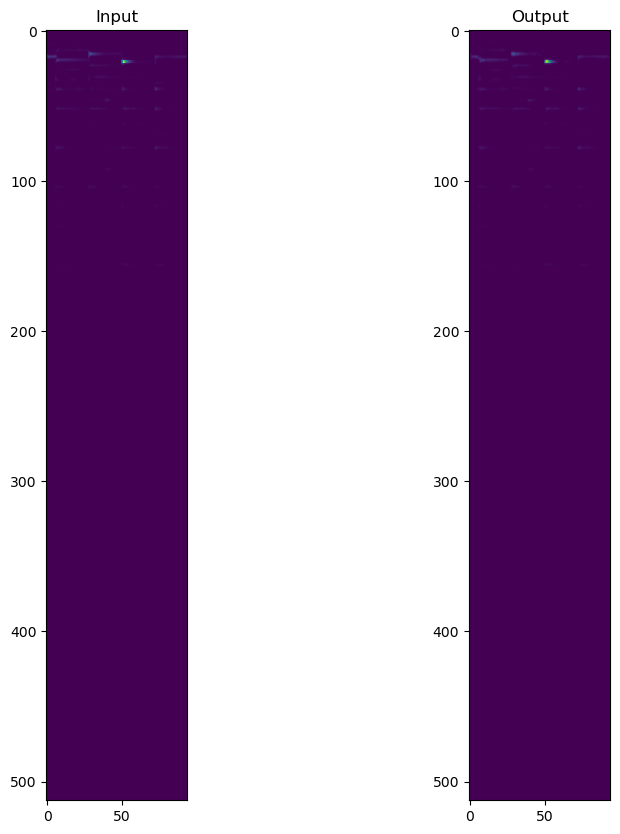

In [12]:
# Reshape to 2D
testing_shaped = testing_shaped.reshape(piano_ds.spec_size[0], piano_ds.spec_size[1])
testing_out_shaped = testing_out_shaped.reshape(piano_ds.spec_size[0], piano_ds.spec_size[1])

# Plotting
fig = plt.figure(figsize=(10, 10))

# Original
fig.add_subplot(1, 2, 1)
plt.imshow(testing_shaped)
plt.title('Input')

# Output
fig.add_subplot(1, 2, 2)
plt.imshow(testing_out_shaped)
plt.title('Output')

plt.show()


# Timbre Modification
If we pass a guitar sample through the piano AE, we will hopefully get the same notes, but with a piano timbre (and vice-versa). When listening to the actual result, you hear a slight modification of the timbre, however not enough to actually resemble the other instrument.

In [13]:
# Pick a guitar sample
guitar_test = guitar_ds_test[0]
# Output through piano autoencoder
guitar_to_piano = autoencoder_piano(guitar_test).clamp(min = 0)

# Recover waveform
guitar_to_piano_wave = recover_waveform(guitar_to_piano.reshape(1, guitar_ds.spec_size[0], guitar_ds.spec_size[1]).detach())
guitar_test_wave = recover_waveform(guitar_test.reshape(1, guitar_ds.spec_size[0], guitar_ds.spec_size[1]).detach())

torchaudio.save('guitar_original.wav', guitar_test_wave, sample_rate)
torchaudio.save('guitar_through_piano.wav', guitar_to_piano_wave , sample_rate)

# Passing a noisy piano
Adding noise to a sample and passing it through the autoencoder should remove the noise. In fact, it does remove some noise, however, it also muffles the sound a little.

In [14]:
piano_test = piano_ds_test[0]
piano_noisy = piano_test + torch.randn(piano_test.shape).clamp(min = 0)

piano_noisy_out = autoencoder_piano(piano_noisy).clamp(min = 0)

piano_test_wave = recover_waveform(piano_test.reshape(1, piano_ds.spec_size[0], piano_ds.spec_size[1]).detach())
piano_noisy_wave = recover_waveform(piano_noisy.reshape(1, piano_ds.spec_size[0], piano_ds.spec_size[1]).detach())
piano_out_wave = recover_waveform(piano_noisy_out.reshape(1, piano_ds.spec_size[0], piano_ds.spec_size[1]).detach())

torchaudio.save('testing_piano.wav', piano_test_wave , sample_rate)
torchaudio.save('testing_piano_noisy.wav', piano_noisy_wave , sample_rate)
torchaudio.save('testing_piano_out.wav', piano_out_wave , sample_rate)

# Mixed Signal Separation

We're taking two different sounds, one which is a piano and the other a guitar. We then add them to make a mixed sound. A suggestion we saw is that if we consider only the decoder part of the autoencoder and perform backwards propagation on the input, using the mixed signal, we should be able to retrieve the original individual sounds.

This takes approximately 5 minutes to run

In [15]:
# Mixing
piano_solo = piano_ds_test[0]
guitar_solo = guitar_ds_test[0]
mix = piano_solo + guitar_solo

# Saving the originals and mix
piano_solo_wave = recover_waveform(piano_solo.reshape(1, piano_ds.spec_size[0], piano_ds.spec_size[1]).detach())
guitar_solo_wave = recover_waveform(guitar_solo.reshape(1, guitar_ds.spec_size[0], guitar_ds.spec_size[1]).detach())
mix_wave = recover_waveform(mix.reshape(1, guitar_ds.spec_size[0], guitar_ds.spec_size[1]).detach())

torchaudio.save('piano_solo.wav', piano_solo_wave , sample_rate)
torchaudio.save('guitar_solo.wav', guitar_solo_wave , sample_rate)
torchaudio.save('mix.wav', mix_wave , sample_rate)

# Backpropagation on the input
rand_input = torch.rand(16, 126, 22)
rand_input.requires_grad = True
# Backpropagation of the input through the piano autoencoder
mix_input_piano, losses_piano = autoencoder_piano.input_gen(output = mix, rand_input = rand_input, epochs = 50_000, 
                                              optimizer = 'adam', criterion = 'mse', lr = 0.05) 
# Backpropagation of the input through the guitar autoencoder
mix_input_guitar, losses_guitar = autoencoder_guitar.input_gen(output = mix, rand_input = rand_input, epochs = 50_000, 
                                                optimizer = 'adam', criterion = 'mse', lr = 0.05) 

# Calculating the outputs
mix_input_piano_output = autoencoder_piano.decoder(mix_input_piano).clamp(min = 0)
mix_input_guitar_output = autoencoder_guitar.decoder(mix_input_guitar).clamp(min = 0)

# Saving the outputs
mix_input_piano_output_wave = recover_waveform(mix_input_piano_output.reshape(1, piano_ds.spec_size[0], piano_ds.spec_size[1]).detach())
mix_input_guitar_output_wave = recover_waveform(mix_input_guitar_output.reshape(1, guitar_ds.spec_size[0], guitar_ds.spec_size[1]).detach())

torchaudio.save('mix_input_piano_output.wav', mix_input_piano_output_wave , sample_rate)
torchaudio.save('mix_input_guitar_output.wav', mix_input_guitar_output_wave , sample_rate)


Even though the losses became really low, it seems that, at least with this model, the retrieval failed.

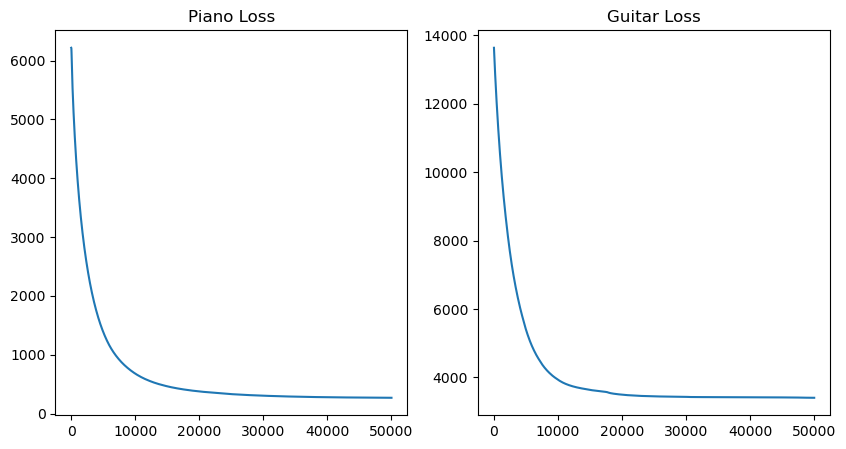

In [16]:
fig = plt.figure(figsize=(10, 5))

# Add piano losses
fig.add_subplot(1, 2, 1)
plt.plot(losses_piano)
plt.title('Piano Loss')

# Add guitar losses
fig.add_subplot(1, 2, 2)
plt.plot(losses_guitar)
plt.title('Guitar Loss')

plt.show()